In [1]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
from specim.specfuncs import spec1d
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
data =  spec1d.Spec1d('../HE0435_spec.fits', informat='mwa')
lamda_galaxy = data['wav']
spectra_galaxy = data['flux']
variance_spectra_galaxy = data['var']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]
#print(data)


Reading spectrum from ../HE0435_spec.fits
Expected file format: mwa
 Spectrum Start:  5570.31
 Spectrum End:     7899.01
 Dispersion (1st pixel):   0.58
 Dispersion (average):      0.58



### Checking whether the redshift calculated from the galaxy spectra is correct by drawing the position of the absoprtion lines with the calculated redshift.


Line        lambda_rest  lambda_obs
----------  -----------  -----------
H-eta         3835.00       5576.09
CN bandhd     3883.00       5645.88
CaII K        3933.67       5719.56
CaII H        3968.47       5770.16
H-delta       4101.00       5962.85
G-band        4305.00       6259.47
H-gamma       4340.00       6310.36
Fe4383        4383.00       6372.88
Ca4455        4455.00       6477.57
Fe4531        4531.00       6588.07
H-beta        4861.00       7067.89
Mg I (b)      5176.00       7525.90



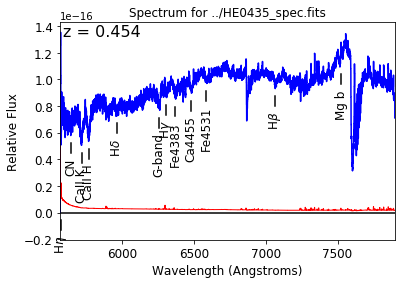

In [3]:
data.plot()
data.mark_lines('abs', z=0.454)

### Normalizing the galaxy spectra with the median value of the spectra.

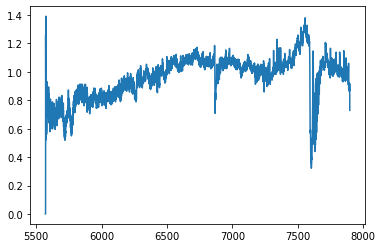

In [4]:
median_spectra_gal = np.median(data['flux'])       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
plt.plot(lamda_galaxy, spectra_galaxy_normalized)
#print(spectra_galaxy_normalized)

### Calculating the velocity scale associated with the galaxy.

In [5]:
c = 299792.458                                 # speed of light in km/s
frac_lamda = lamda_galaxy[1]/ lamda_galaxy[0]  # Constant lambda fraction per pixel
velocity_scale =  np.log(frac_lamda)*c         # velocity scale in km/s per pixel
print('Velocity_scale=', velocity_scale)

Velocity_scale= 31.213817586671198


### Logarithmically rebinning the galaxy spectra.

In [6]:
spectra_galaxy_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy_normalized, 
                                                         velscale=velocity_scale)

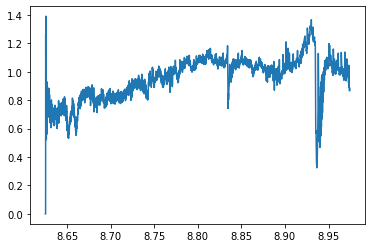

In [7]:
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)

### Loading one of the template spectra from the library to obtain the wavelength range of the template spectra.

In [8]:
template_data = spec1d.Spec1d('../TEXT/101484.txt')
lamda_template = template_data['wav']                      # wavelength in angstrom
spectra_template = template_data['flux']                     # spectra
lamda_template_range = [np.min(lamda_template), np.max(lamda_template)]
#print(lamda_template_range)


Reading spectrum from ../TEXT/101484.txt
Expected file format: text
 Spectrum Start:  3465.00
 Spectrum End:     9469.00
 Dispersion (1st pixel):   0.40
 Dispersion (average):      0.40



### Checking whether the wavelength range of the tamplate spectra covers the galaxy spectra given the redshift.

In [9]:
z = 0.454
lam_range_min = lamda_template_range[0]*(1+z)
lam_range_max = lamda_template_range[1]*(1+z)
print(lam_range_min)
print(lam_range_max)

5038.11
13767.926


### Logarithmically rebinning the template spectra.

In [10]:
spectra_template_rebinned, log_lamda_template, vscale = util.log_rebin(lamda_template_range, spectra_template,
                                                                  velscale=velocity_scale)

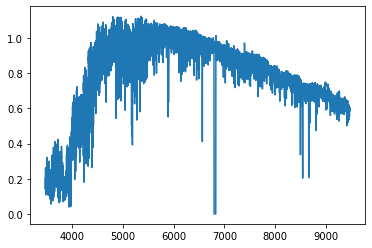

In [11]:
plt.plot(lamda_template, spectra_template)

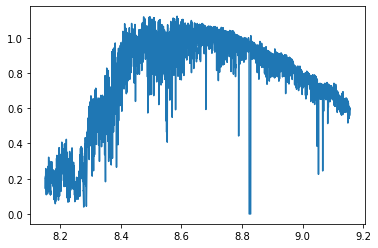

In [12]:
plt.plot(log_lamda_template, spectra_template_rebinned)

### Calculating FWHM of the galaxy spectra where sigma of the instrument has been obtained by performing Gaussian fit with several emission lines from the galaxy spectra.

In [13]:
sigma_instrument = 0.95                           #sigma of the instrumental LSF
fwhm_galaxy = 2.355 * sigma_instrument           # FWHM of every pixel in Angstrom
fwhm_galaxy_spectra  = np.full(len(lamda_galaxy), fwhm_galaxy)
print(fwhm_galaxy)

2.23725


In [14]:
fwhm_template_spectra = 1.0        # in Angstrom
pixel_size_tem_spec = 0.40           # in Angstrom

In [15]:
fwhm_interp_gal_spec = np.interp(lamda_template, lamda_galaxy, fwhm_galaxy_spectra)  #interpolated fwhm
fwhm_diff = np.sqrt(fwhm_interp_gal_spec**2 - fwhm_template_spectra**2)
sigma_diff = fwhm_diff / 2.355

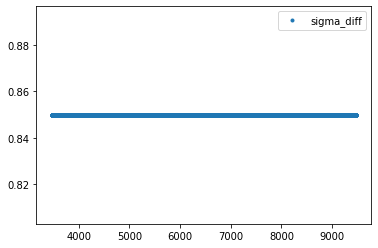

In [16]:
plt.plot(lamda_template, sigma_diff,'.', label='sigma_diff')
plt.legend()

### Laoding the template library, then convolve each spectrum with a Gaussian having a sigma equal to 'sigma_diff' and finally logarithmically rebinning the spectrum.

In [17]:
indo_us_library = glob.glob('../TEXT/*')[:850]
templates = np.empty((spectra_template_rebinned.size, len(indo_us_library)))

In [18]:
for j, file_name in enumerate(indo_us_library):
     
    template_data = spec1d.Spec1d(file_name, verbose=False)
    template_spectra = template_data['flux']

    # perform convolution with variable sigma_diff    
    convolved_temp_spectra= util.gaussian_filter1d(template_spectra, sigma_diff)  

    template_spectra_rebinned = util.log_rebin(lamda_template_range, convolved_temp_spectra, 
                                          velscale=velocity_scale)[0]
    templates[:, j] = template_spectra_rebinned / np.median(template_spectra_rebinned) # Normalizes templates

In [20]:
dv = c*np.log(lamda_template[0]/lamda_galaxy[0]) 

In [21]:
z = 0.454              # redshift from input spectra
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  
#print(vel)

### Taking care of noise here.

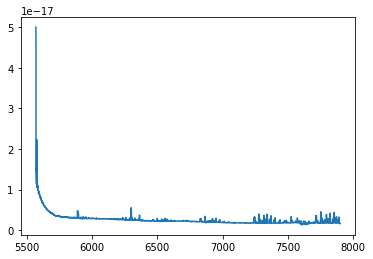

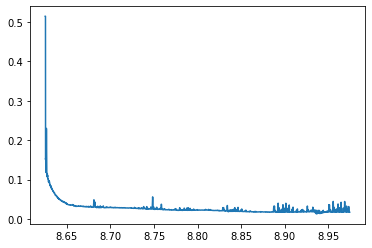

In [22]:
sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
noise = sigma_galaxy_spectra / median_spectra_gal

noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range,
                                                             noise,
                                                           velscale=velocity_scale)
plt.plot(lamda_galaxy, sigma_galaxy_spectra)
plt.figure()
#print(velo_scale)
#print(np.size(noise_new))
plt.plot(log_lamda_noise, noise_rebinned)

### Fitting the galaxy spectra without masking.

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    114218       529     0.300     0.300
chi2/DOF: 20.05
method = capfit; Jac calls: 32; Func calls: 175; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 850


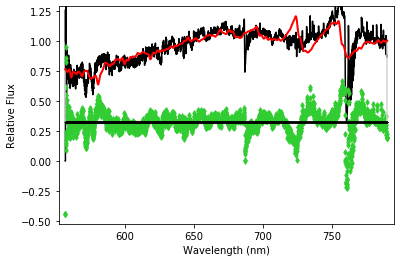

In [23]:
pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, lam=np.exp(log_lamda_galaxy))

### Fitting the galaxy spectra with masking.

In [24]:
def masking(length, pixel_range, log_lamda_gal):
    '''
    This function generate and returns a boolean array with value 'False'
    in the pixel locations which should be excluded from the fit.
    
    Parameters
    ---------------
    length: int
        The length of the logarithmically rebinned galaxy spectra. The 
        boolean array would be of the same size.
        
    pixel_range: list
        A list of tuples where each tuple contains start and end of the
        pixel range needs to be excluded.
        
    log_lamda_gal: array
        This array contains the values of the logarithmically 
        rebinned wavelengths.
    
    Returns
    -------------
    mask : boolean array
        Boolean array with with value 'False' in the pixel locations 
        which should be excluded from the fit.
        
    '''
    
    mask = np.zeros(length, dtype=bool)
    for i,p in enumerate(pixel_range):
        mask |= (log_lamda_gal>=p[0]) & (log_lamda_gal <= p[1])
    return (~mask)

In [25]:
pixel_range = [(8.8305, 8.8422), (8.91412, 8.94774)]

In [26]:
mask = masking(spectra_galaxy_rebinned.size, pixel_range, log_lamda_galaxy)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112207       248    -0.030     0.018
chi2/DOF: 1.569
method = capfit; Jac calls: 3; Func calls: 17; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  16 / 850


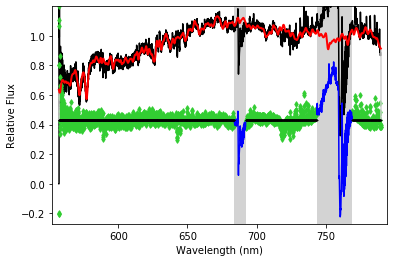

In [27]:
pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, mask=mask, lam=np.exp(log_lamda_galaxy))

### Here we are varying the parameter 'degree' to check how the velocity dispersion value changes.

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112207       248    -0.030     0.018
chi2/DOF: 1.569
method = capfit; Jac calls: 3; Func calls: 17; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  16 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112205       248    -0.026     0.027
chi2/DOF: 1.425
method = capfit; Jac calls: 3; Func calls: 17; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  15 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112206       231    -0.018    -0.011
chi2/DOF: 1.359
method = capfit; Jac calls: 3; Func calls: 17; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  11 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112203       224    -0.026    -0.023
chi2/DOF: 1.335
method = capfit; Jac calls: 3; Func calls: 17; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    

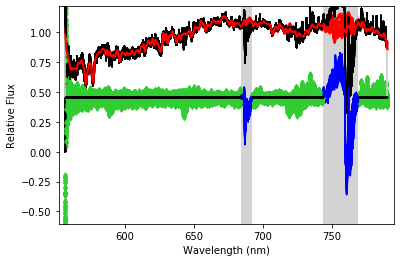

In [28]:
degree = np.arange(4,25)
velocity_dispersion = np.zeros(len(degree))
for i in range(len(degree)):
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, degree=degree[i], vsyst=dv, mask= mask, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1]

<Figure size 432x288 with 0 Axes>

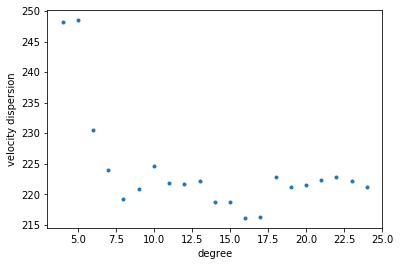

<Figure size 432x288 with 0 Axes>

In [29]:
#m, b = np.polyfit(degree, velocity_dispersion, 1)

plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()
#plt.plot(degree[1:], m*degree[1:] + b)

## plotting the same plot without the first value of the degree array which is degree=4 

#plt.plot(degree[1:], velocity_dispersion[1:], '.')
#plt.xlabel('degree')
#plt.ylabel('velocity dispersion')

In [34]:
# Extended masking

pixel_range_new = [(8.6252, 8.62938), (8.8268, 8.84623), (8.91133, 8.9749)]

In [35]:
mask = masking(spectra_galaxy_rebinned.size, pixel_range_new, log_lamda_galaxy)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112210       237    -0.030     0.011
chi2/DOF: 1.193
method = capfit; Jac calls: 2; Func calls: 12; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  13 / 850


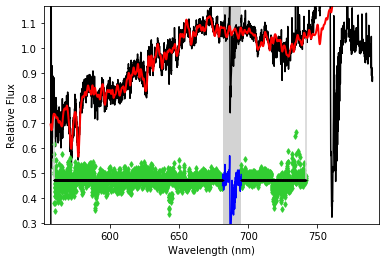

In [36]:
pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, mask=mask, lam=np.exp(log_lamda_galaxy))

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112210       237    -0.030     0.011
chi2/DOF: 1.193
method = capfit; Jac calls: 2; Func calls: 12; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  13 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112211       220    -0.019    -0.029
chi2/DOF: 1.133
method = capfit; Jac calls: 2; Func calls: 12; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  11 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112205       214    -0.029    -0.054
chi2/DOF: 1.074
method = capfit; Jac calls: 2; Func calls: 12; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  11 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    112207       218    -0.024    -0.033
chi2/DOF: 1.063
method = capfit; Jac calls: 2; Func calls: 12; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  10 / 850
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:   

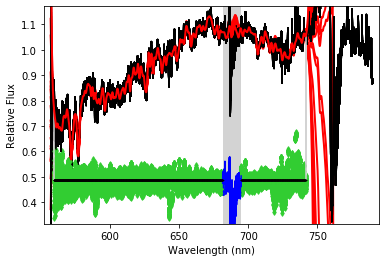

In [37]:
degree = np.arange(4,25)
velocity_dispersion = np.zeros(len(degree))
for i in range(len(degree)):
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, degree=degree[i], vsyst=dv, mask= mask, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1]

<Figure size 432x288 with 0 Axes>

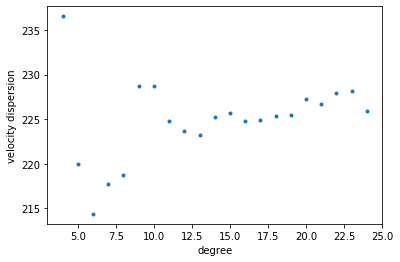

<Figure size 432x288 with 0 Axes>

In [38]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
plt.figure()